In [2]:
import sys
sys.path.append("..")

import pickle
import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol, sin, cos, tan, nsimplify
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
# from optical_bloch.utils.general import flatten
# from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from optical_bloch_test.utils.general import flatten
from optical_bloch_test import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

from julia import Main
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

In [3]:
hbar=1.054*1E-34; #[Js]
k_b=1.381*1E-23; #[J/K]
c=299792000; #[m/s]
eps_0=8.854*1E-12; #[F/m]
a0=5.29*1E-11; #[m]
q_e=1.602*1E-19; #[C]
Bohr_mag=1.39962449/1000*2*np.pi; #[GHz/G]

nground = 3
nexcite = 3
ntotal = 6

In [4]:
rabi_matrix = np.zeros([ntotal,ntotal,3])
rabi_matrix[:,:,0] = np.genfromtxt('rabimatrix33toy1.csv',delimiter=',')
rabi_matrix[:,:,1] = np.genfromtxt('rabimatrix33toy2.csv',delimiter=',')
rabi_matrix[:,:,2] = np.genfromtxt('rabimatrix33toy3.csv',delimiter=',')

In [5]:
E0 = Symbol(u'E0', real = True)
Ee = Symbol(u'Ee', real = True)

ω = Symbol(u'ω', real = True)
Ω = Symbol(u'Ω', real = True)
Δ = Symbol(u'Δ', real = True)
g = Symbol(u'g', real = True)

θ = Symbol(u'θ', real = True)
B = Symbol(u'B', real = True)

In [6]:
ham = Hamiltonian(ntotal)
ham.addEnergies([E0-g*B,E0,E0+g*B,
                 Ee,Ee,Ee])
# ham.addEnergies([E0-2*g*B,E0-g*B,E0,E0+g*B, E0+2*g*B,
#                  Ee-g*B,Ee,Ee+g*B])

In [7]:
for i in range(nground):
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,0], ω)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (1)*cos(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,1], ω)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = (1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,2], ω)

In [8]:
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineEnergyDetuning(E0, Ee, Δ, ω)

In [9]:
ham.transformed

Matrix([
[               -B*g - 1.0*Δ,                           0,                           0, -0.166666666666666*Ω*cos(θ), -0.117851130197758*Ω*sin(θ),                           0],
[                          0,                      -1.0*Δ,                           0, -0.117851130197758*Ω*sin(θ),                           0, -0.117851130197758*Ω*sin(θ)],
[                          0,                           0,                 B*g - 1.0*Δ,                           0, -0.117851130197758*Ω*sin(θ),  0.166666666666666*Ω*cos(θ)],
[-0.166666666666666*Ω*cos(θ), -0.117851130197758*Ω*sin(θ),                           0,                           0,                           0,                           0],
[-0.117851130197758*Ω*sin(θ),                           0, -0.117851130197758*Ω*sin(θ),                           0,                           0,                           0],
[                          0, -0.117851130197758*Ω*sin(θ),  0.166666666666666*Ω*cos(θ),                        

In [10]:
ham.hamiltonian

Matrix([
[                                  -B*g + E0,                                           0,                                           0, -0.166666666666666*Ω*exp(1.0*I*t*ω)*cos(θ), -0.117851130197758*Ω*exp(1.0*I*t*ω)*sin(θ),                                          0],
[                                          0,                                          E0,                                           0, -0.117851130197758*Ω*exp(1.0*I*t*ω)*sin(θ),                                          0, -0.117851130197758*Ω*exp(1.0*I*t*ω)*sin(θ)],
[                                          0,                                           0,                                    B*g + E0,                                          0, -0.117851130197758*Ω*exp(1.0*I*t*ω)*sin(θ),  0.166666666666666*Ω*exp(1.0*I*t*ω)*cos(θ)],
[-0.166666666666666*Ω*exp(-1.0*I*t*ω)*cos(θ), -0.117851130197758*Ω*exp(-1.0*I*t*ω)*sin(θ),                                           0,                                         Ee,     

In [11]:
transition_strengths=np.zeros([ntotal,ntotal]);
for i in range(ntotal):
    for f in range(ntotal):
        for p in range(3):
            transition_strengths[i,f]=transition_strengths[i,f]+rabi_matrix[i,f,p]**2

In [12]:
BR = np.zeros([ntotal, ntotal])
for i in range(ntotal):
    sums=0
    for f in range(ntotal):
        sums=sums+transition_strengths[i,f]
        
    for f in range(ntotal):
        BR[i,f]=transition_strengths[i,f]/sums
        
for i in range(nground):
    BR[i,:]=0

In [13]:
BR[nground:,:]

array([[0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. ]])

In [14]:
Γ = Symbol(u'Γ', real = True)
dis = Dissipator(ntotal)

for exct in tqdm(range(nground, ntotal)):
    for grnd in range(nground):
        if BR[exct, grnd] != 0:
            dis.addDecay(exct, grnd, Γ * BR[exct, grnd])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.49it/s]


In [15]:
dis.dissipator

Matrix([
[ 0.5*Γ*(ρ₃₃(t) + ρ₄₄(t)),                        0,                        0,            -0.5*Γ*ρ₀₃(t),            -0.5*Γ*ρ₀₄(t), -0.5*Γ*ρ₀₅(t)],
[                       0,  0.5*Γ*(ρ₃₃(t) + ρ₅₅(t)),                        0,            -0.5*Γ*ρ₁₃(t),            -0.5*Γ*ρ₁₄(t), -0.5*Γ*ρ₁₅(t)],
[                       0,                        0,  0.5*Γ*(ρ₄₄(t) + ρ₅₅(t)),            -0.5*Γ*ρ₂₃(t),            -0.5*Γ*ρ₂₄(t), -0.5*Γ*ρ₂₅(t)],
[-0.5*Γ*conjugate(ρ₀₃(t)), -0.5*Γ*conjugate(ρ₁₃(t)), -0.5*Γ*conjugate(ρ₂₃(t)),            -1.0*Γ*ρ₃₃(t),            -1.0*Γ*ρ₃₄(t), -1.0*Γ*ρ₃₅(t)],
[-0.5*Γ*conjugate(ρ₀₄(t)), -0.5*Γ*conjugate(ρ₁₄(t)), -0.5*Γ*conjugate(ρ₂₄(t)), -1.0*Γ*conjugate(ρ₃₄(t)),            -1.0*Γ*ρ₄₄(t), -1.0*Γ*ρ₄₅(t)],
[-0.5*Γ*conjugate(ρ₀₅(t)), -0.5*Γ*conjugate(ρ₁₅(t)), -0.5*Γ*conjugate(ρ₂₅(t)), -1.0*Γ*conjugate(ρ₃₅(t)), -1.0*Γ*conjugate(ρ₄₅(t)), -1.0*Γ*ρ₅₅(t)]])

In [16]:
%%time
bloch = BlochEquations(ntotal, dis.density_matrix, ham.transformed, dis.dissipator)

start generateEquations
Wall time: 532 ms


In [17]:
Ω_value = 20
replacements = [(g, 1),
                (Δ, 0),
                (Ω, Ω_value),
                (Γ, 1)]
varlist1 = np.linspace(0.01,np.pi,100)
varlist2 = 10**np.linspace(-3,1,100)
# np.linspace(0.001,5,100)
sol = bloch.solveSteadyStateNumeric(replacements = replacements, parameters_scan = [θ, B], scan_ranges = [varlist1, varlist2])

AttributeError: 'BlochEquations' object has no attribute 'equations_steady_state'

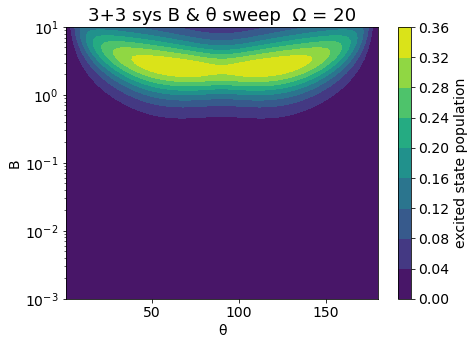

In [43]:
soltemp = sol.reshape([len(varlist1), len(varlist2), ntotal, ntotal])
ρii = np.array([np.real(soltemp[:,:,i,i]) for i in range(ntotal)])
params = np.array(np.meshgrid(varlist1, varlist2)).T.reshape(-1,2)

fig, ax = plt.subplots(figsize = (7,5))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], 
                     np.sum(np.array([ρii[_,:,:].reshape(len(varlist1)*len(varlist2)) 
                                      for _ in range(nground, ntotal)]), axis = 0) ,levels=10)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
ax.set_yscale('log')
ax.set_title(f'3+3 sys B & θ sweep  Ω = {Ω_value}')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [45]:
filenames = []
y = np.concatenate((np.linspace(0.1, 2, 20), np.linspace(2.2, 8, 20)), axis=None)
for i in y:
    Ω_value = i
    replacements = [(g, 1),
                    (Δ, 0),
                    (Ω, Ω_value),
                    (Γ, 1)]
    
    varlist1 = np.linspace(0.01,np.pi,50)
    varlist2 = 10**np.linspace(-3,1,50)
    sol = bloch.solveSteadyStateNumeric(replacements = replacements, parameters_scan = [θ, B], scan_ranges = [varlist1, varlist2])
    soltemp = sol.reshape([len(varlist1), len(varlist2), ntotal, ntotal])
    ρii = np.array([np.real(soltemp[:,:,i,i]) for i in range(ntotal)])
    
    fig, ax = plt.subplots(figsize = (7,5))

    params = np.array(np.meshgrid(varlist1, varlist2)).T.reshape(-1,2)
    tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], 
                         np.sum(np.array([ρii[_,:,:].reshape(len(varlist1)*len(varlist2)) 
                                          for _ in range(nground, ntotal)]), axis = 0) ,levels=10)

    cbar = fig.colorbar(tcf)

    ax.set_xlabel('θ')
    ax.set_ylabel('B')
    cbar.ax.set_ylabel('excited state population')
    ax.set_yscale('log')
    ax.set_title(f'3+3 sys B & θ sweep  Ω = {Ω_value}')
    set_fontsize(ax, 14)
    set_fontsize(cbar.ax, 14)
    
    # create file name and append it to a list
    filename = f'{i}.png'
    for i in range(10):
        filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
    
# build gif
with imageio.get_writer('3+3 sys.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 3884.22it/s]


In [40]:
B_value = 0.3
Ω_value = 3
replacements = [(g, 1),
                (B, B_value),
                (Δ, 0),
                (Ω, Ω_value),
                (Γ, 1)]
varlist = np.linspace(0.01,np.pi,100)
sol = bloch.solveSteadyStateNumeric(replacements = replacements, parameters_scan = θ, scan_ranges = [varlist])
arr = np.array([[np.sqrt(2)*np.cos(θ), np.sin(θ), np.sin(θ), np.sin(θ), np.sin(θ), np.sqrt(2)*np.cos(θ)] for θ in varlist])

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3485.78it/s]


Text(0.5, 0.98, '5+3 sys  $B$ = 0.3  Ω = 3  X = angle')

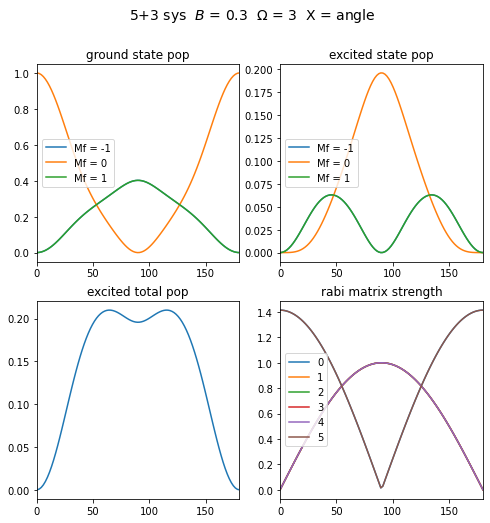

In [41]:
soltemp = sol.reshape([-1,ntotal,ntotal])
ρii = np.array([np.real(soltemp[:,i,i]) for i in range(ntotal)])
std = np.array([np.sum(np.abs(arr[i])) for i in range(len(arr))])

fig, ax = plt.subplots(2,2, figsize = (8,8))
for _ in range(0,nground):
    ax[0,0].plot(varlist/np.pi*180, ρii[_,:], label = "Mf = "+str(_-1))
for _ in range(nground,ntotal):
    ax[0,1].plot(varlist/np.pi*180, ρii[_,:], label = "Mf = "+str(_-4))
ax[1,0].plot(varlist/np.pi*180, ρii[3,:]+ρii[4,:]+ρii[5,:])

for i in range(6):
    ax[1,1].plot(varlist/np.pi*180, np.abs(arr[:,i]), label = str(i))
ax[0,0].legend(loc = 6)
ax[0,1].legend(loc = 6)
# ax[1,0].legend()
ax[1,1].legend(loc = 6)
ax[0,0].set_xlim(0,180)
ax[0,1].set_xlim(0,180)
ax[1,0].set_xlim(0,180)
ax[1,1].set_xlim(0,180)
ax[0,0].set_title('ground state pop')
ax[0,1].set_title('excited state pop')
ax[1,0].set_title('excited total pop')
ax[1,1].set_title('rabi matrix strength')
fig.suptitle(f"5+3 sys  $B$ = {B_value}  Ω = {Ω_value}  X = angle", fontsize=14)
# fig.supxlabel('1')

In [ ]:
θ